In [0]:
# !unzip Dataset.zip
import zipfile
with zipfile.ZipFile("Dataset.zip","r") as folder: 
  folder.extractall("/content/")

In [0]:

import os
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import math
import sklearn.metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from itertools import permutations  
from scipy.stats import entropy
import sklearn.metrics  
import pandas as pd
 

# ***Methods used for reading and visualizing the data***

In [0]:
def readDataset():
  matrices = []
  labels = []
  directory = "./Dataset"
  for filename in sorted(os.listdir(directory)):
    if filename.startswith("t"):
      graph = graphReader(directory + "/" + filename)
      matrices.append(graph)
    else:
      labels = labelsReader(directory + "/" + filename)
  return matrices, labels

def graphReader(filename):
  size = int(filename[filename.find("_")+1 : filename.rfind("_")])
  adjacency_matrix = np.zeros((size, size))
  f = open(filename, "r")
  while True:
    line = f.readline()
    if line is None or len(line) == 0:
      break
    strips = line.split(" ")
    node1,node2,weight = int(strips[0]),int(strips[1]),int(strips[2])
    adjacency_matrix[node1-1][node2-1] += weight
    adjacency_matrix[node2-1][node1-1] += weight
  return adjacency_matrix

def labelsReader(filename):
  f = open(filename, "r")
  labels = []
  while True:
    line = f.readline()
    if line is None or len(line) == 0:
      break
    strips = line.split(" ")
    strips = list(map(int, strips))
    labels.append(strips)
  return labels

def visualize(adjacency):
  plt.figure(figsize=(10,10))
  rows, cols = np.where(adjacency != 0)
  adjacency = adjacency[np.triu_indices(len(adjacency), k = 1)]
  weights = adjacency[np.nonzero(adjacency)]
  edges = zip(rows.tolist(), cols.tolist(), weights.tolist())
  gr = nx.Graph()
  gr.add_weighted_edges_from(edges)
  pos=nx.spring_layout(gr, k=400)
  # pos = list(pos.values())
  # pos = np.array(pos).reshape((len(pos), 2))
  # pos = nx.rescale_layout(pos, scale=1)
  nx.draw(gr, pos,node_size=100)
  labels = nx.get_edge_attributes(gr,'weight')
  nx.draw_networkx_edge_labels(gr,pos,edge_labels=labels, width=1.0, alpha=0.5)
  plt.show()
  plt.tight_layout()

def visualize2(adjacency, pred_labels):
  plt.figure(figsize=(5,5))
  gr = nx.from_numpy_matrix(adjacency)
  pos=nx.spring_layout(gr, k=400)
  for i,node in enumerate(gr.nodes()):
    gr.nodes[node]["cluster"] = pred_labels[i]
  color_map = plt.get_cmap("tab20c", len(np.unique(pred_labels)))
  colors = color_map.colors
  nx.draw(gr,pos,node_size=100, node_color=[colors[gr.nodes[node]["cluster"]] for node in gr])
  labels = nx.get_edge_attributes(gr,'weight')
  nx.draw_networkx_edge_labels(gr,pos,edge_labels=labels, width=1.0, alpha=0.5)
  plt.show()
  plt.tight_layout()

# ***Methods used for Spectral Clustering***

In [0]:
def SpectralClustering(A, k):
  graph = nx.Graph(A)
  Ls = nx.normalized_laplacian_matrix(graph).toarray()
  # degree_vec = [val for (node,val) in graph.degree()]
  # D = np.diag(degree_vec)                   # Degree matrix
  # L = D - A  
  # D_inv = np.linalg.pinv(D,hermitian=True)
  # La = np.dot(D_inv,L)
  # eigVal,eigVec = np.linalg.eigh(La)
  eigVal,eigVec = np.linalg.eigh(Ls)
  # indices = eigVal.argsort()
  # eigVal = eigVal[indices]
  # eigVec = eigVec[:,indices]
  # eigVec = eigVec[::-1]
  U = eigVec[:, :k]
  Y = normalize(U, axis=1)
  cluster_labels = Kmeans(U, k)
  return cluster_labels

def Kmeans(data, k):
  kmeans =  KMeans(n_clusters=k)
  return kmeans.fit_predict(data)

# Helper method that matches the predicted clusters
# their corresponding match in ground trush
def remap_labels(pred_labels, true_labels):
    pred_labels, true_labels = np.array(pred_labels), np.array(true_labels)
    assert pred_labels.ndim == 1 == true_labels.ndim
    assert len(pred_labels) == len(true_labels)
    cluster_names = np.unique(pred_labels)
    accuracy = 0

    perms = np.array(list(permutations(np.unique(pred_labels))))
    print(perms)
    remapped_labels = true_labels
    for perm in perms:
        flipped_labels = np.zeros(len(true_labels))
        for label_index, label in enumerate(cluster_names):
            flipped_labels[pred_labels == label] = perm[label_index]

        testAcc = np.sum(flipped_labels == true_labels) / len(true_labels)
        if testAcc > accuracy:
            accuracy = testAcc
            remapped_labels = flipped_labels

    return remapped_labels
  
def labelsMapper(labels):
  clusters = list(pd.unique(labels))
  # print(clusters)
  for i in range(len(labels)):
    labels[i] = clusters.index(labels[i])
  return labels



# ***Methods used for Evaluation***

In [0]:
def F1Measure(labels, ground_truth):
  labels = set(labels)
  ground_truth = set(ground_truth)
  true_positives = len(labels & ground_truth)
  false_positives = len(ground_truth) - true_positives
  false_negatives = len(labels) - true_positives

  if true_positives > 0:
    precision = float(true_positives) / (true_positives + false_positives)
    recall = float(true_positives)/ (true_positives + false_negatives)

    return 2*((precision*recall)/(precision+recall))
  else:
    return 0

def F1Score(labels, ground_truth):  # assumes clusters/classes are numbered from 0 to N
  number_of_classes = max( len(np.unique(labels)) , len(np.unique(ground_truth)) )
  # confusion_matrix = np.zeros((number_of_classes, number_of_classes))

  confusion_matrix = sklearn.metrics.confusion_matrix(ground_truth, labels)
  # for i in range(len(labels)):
  #   confusion_matrix[ground_truth[i]][labels[i]] += 1
  
  true_positives = np.sum(np.diagonal(confusion_matrix))
  accuracy = true_positives/len(labels)

  precision = 0.0
  f1 = 0.0

  for i in range(number_of_classes):
    support = np.sum(confusion_matrix[i])
    preds = np.sum(confusion_matrix[:,i])

    if support != 0:
      score = confusion_matrix[i][i] * support
      f1 += score/(support + preds)
    
    if preds != 0:
      precision += score/preds
  
  precision = precision / len(labels)
  f1 = 2*f1/len(labels)
    
  return accuracy, precision, f1

def conditionalEntropy(labels, ground_truth):
  number_of_clusters, count = np.unique(labels, return_counts=True)
  number_of_partitions, countP = np.unique(ground_truth, return_counts=True)
  class_entropy = []
  for i in range(len(number_of_clusters)):
    entropy = 0
    indices = [j for j, x in enumerate(labels) if x == i]
    cardinality = count[i]
     
    for j in range(len(number_of_partitions)):
      matches = len([ground_truth[k] for k in indices if ground_truth[k] == j])       
      if matches == 0:
        continue
      term = matches/cardinality
      entropy += -1*term*math.log2(term)
    class_entropy.append(entropy)
  total_entropy = 0
  # print(class_entropy)
  for i in range(len(class_entropy)):
    total_entropy += (count[i]/len(labels)) * class_entropy[i]
  return total_entropy


def normalizedCut(adjacency, labels):
    NC = 0.0
    distances = eval_distance(adjacency)
    classes = np.unique(labels)
    number_of_classes = len(classes)
    cluster_distances = np.zeros((number_of_classes, 2))
    for i in range(number_of_classes):
        indices = [j for j, x in enumerate(labels) if x == i]
        if len(indices) == 0:
            cluster_distances[i][0] = 0
        else:
            for j in range(len(indices)-1):
                for k in range(j+1,len(indices)):
                    cluster_distances[i][0] += distances[indices[j]][indices[k]]
        indices2 = [j for j, x in enumerate(labels) if x != i]
        for j in range(len(indices)):
            for k in range(len(indices2)):
                cluster_distances[i][1] += distances[indices[j]][indices2[k]]
    for row in range(cluster_distances.shape[0]):
        NC += (cluster_distances[row][1]/ (cluster_distances[row][1] + cluster_distances[row][0]))
    return NC



def eval_distance(adjacency):
    distances = np.zeros((adjacency.shape[0], adjacency.shape[1]))
    for i in range(adjacency.shape[0]):
        for j in range(adjacency.shape[1]):
            distances[i][j] = math.exp(-0.01 * adjacency[i][j])
    np.fill_diagonal(distances, 0)
    return distances

def traffic(adjacency,labels):
  distances = adjacency
  classes = np.unique(labels)
  number_of_classes = len(classes)
  cluster_distances = np.zeros((number_of_classes, 2))
  for i in range(number_of_classes):
      indices = [j for j, x in enumerate(labels) if x == i]
      if len(indices) == 0:
          cluster_distances[i][0] = 0
      else:
          for j in range(len(indices)-1):
              for k in range(j+1,len(indices)):
                  cluster_distances[i][0] += distances[indices[j]][indices[k]]
      indices2 = [j for j, x in enumerate(labels) if x != i]
      for j in range(len(indices)):
          for k in range(len(indices2)):
              cluster_distances[i][1] += distances[indices[j]][indices2[k]]
  return cluster_distances 

# ***Reading and splitting the topologies***

In [0]:
graphs, labels = readDataset()
x_100 = np.asarray(graphs[0:10])
x_10 = np.asarray(graphs[10:20])
x_50 = np.asarray(graphs[20:30])
y_true_10 = np.asarray(labels[0:10])
y_true_50 = np.asarray(labels[10:20])

# ***Visualizing the topologies***

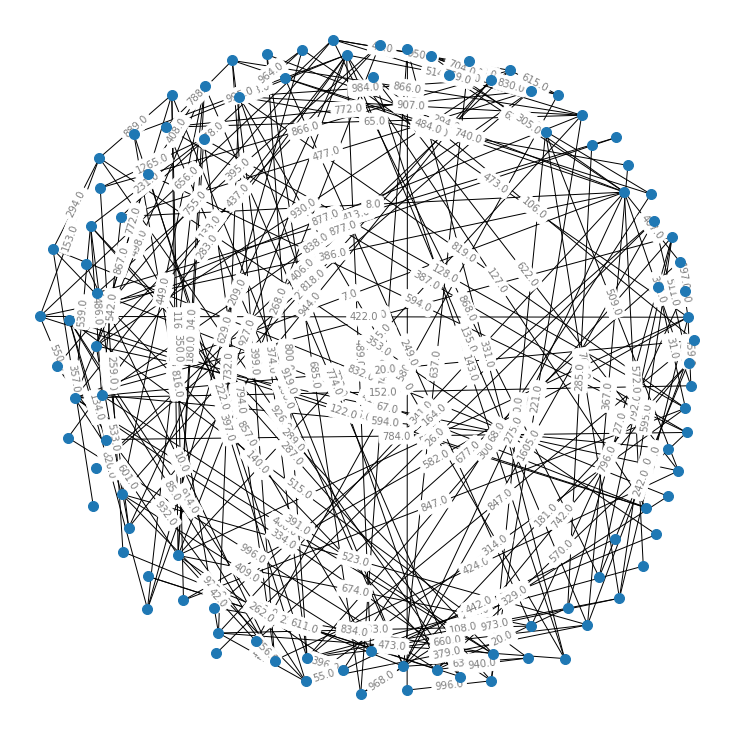

<Figure size 432x288 with 0 Axes>

In [0]:
visualize(graphs[9])

In [0]:
k_10 = [2,4,6,8,10]
k_50 = [2,10,12,15,17,20,25]
k_100 = [2,10,12,15,17,20,25]

In [0]:
best_clusters = []
best_k = []
best_f1 = []
best_entropy = []
counter = 0

for topology,ground_truth in zip(x_10,y_true_10):
  print("Topology #",counter)
  f1_all_k = []
  entropy_all_k = []
  all_preds = []

  for k in k_10:
    print("   K =  ",k)
    y_pred_10 = np.asarray(SpectralClustering(topology, k)).astype(int) 
    y_pred_10 = np.asarray(labelsMapper(y_pred_10)).astype(int)
    ground_truth = np.asarray(labelsMapper(ground_truth)) 
    _,_,f1= F1Score(y_pred_10, ground_truth)
    c_entropy = conditionalEntropy(y_pred_10, ground_truth)
    print("     F1 score   = ",f1)
    print("     C. Entropy = ",c_entropy)
    all_preds.append(y_pred_10)
    f1_all_k.append(f1)
    entropy_all_k.append(c_entropy)

  max_f1_index = np.argmax(f1_all_k)
  min_entropy_index = np.argmin(entropy_all_k)
  print("Clustering with max f1 is ", all_preds[max_f1_index])
  print("Clustering with min entropy is ", all_preds[min_entropy_index])
  print("\n\n")
  best_clusters.append(all_preds[max_f1_index])
  best_k.append(k_10[max_f1_index])
  best_entropy.append(min(entropy_all_k))
  best_f1.append(max(f1_all_k))
  counter = counter + 1


Topology # 0
   K =   2
     F1 score   =  0.15
     C. Entropy =  1.9774437510817342
   K =   4
     F1 score   =  0.31
     C. Entropy =  1.4754887502163467
   K =   6
     F1 score   =  0.2866666666666667
     C. Entropy =  0.8
   K =   8
     F1 score   =  0.31666666666666665
     C. Entropy =  0.4
   K =   10
     F1 score   =  0.35
     C. Entropy =  0.0
Clustering with max f1 is  [0 1 2 3 4 5 6 7 8 9]
Clustering with min entropy is  [0 1 2 3 4 5 6 7 8 9]



Topology # 1
   K =   2
     F1 score   =  0.5619047619047619
     C. Entropy =  0.963547202339972
   K =   4
     F1 score   =  0.5333333333333333
     C. Entropy =  0.47548875021634684
   K =   6
     F1 score   =  0.30476190476190473
     C. Entropy =  0.4
   K =   8
     F1 score   =  0.30476190476190473
     C. Entropy =  0.4
   K =   10
     F1 score   =  0.17142857142857143
     C. Entropy =  0.0
Clustering with max f1 is  [0 1 0 0 0 1 0 0 0 0]
Clustering with min entropy is  [0 1 2 3 4 5 6 7 8 9]



Topology # 2
   K 

In [0]:
counter = 0

for topology,ground_truth in zip(x_50,y_true_50):
  print("Topology #",counter)
  f1_all_k = []
  entropy_all_k = []
  all_preds = []
  for k in k_50:
    print("   K =  ",k)
    y_pred_50 = np.asarray(SpectralClustering(topology, k)).astype(int) 
    y_pred_50 = np.asarray(labelsMapper(y_pred_50)).astype(int)
    ground_truth = np.asarray(labelsMapper(ground_truth)) 
    _,_,f1= F1Score(y_pred_50, ground_truth)
    c_entropy = conditionalEntropy(y_pred_50, ground_truth)
    print("     F1 score   = ",f1)
    print("     C. Entropy = ",c_entropy)
    all_preds.append(y_pred_50)
    f1_all_k.append(f1)
    entropy_all_k.append(c_entropy)
  max_f1_index = np.argmax(f1_all_k)
  min_entropy_index = np.argmin(entropy_all_k)
  print("Clustering with max f1 is ", all_preds[max_f1_index])
  print("Clustering with min entropy is ", all_preds[min_entropy_index],"\n\n")

  best_clusters.append(all_preds[max_f1_index])
  best_k.append(k_50[max_f1_index])
  best_entropy.append(min(entropy_all_k))
  best_f1.append(max(f1_all_k))
  counter = counter + 1


Topology # 0
   K =   2
     F1 score   =  0.02618181818181818
     C. Entropy =  3.052025529332476
   K =   10
     F1 score   =  0.09858585858585858
     C. Entropy =  2.16363059062335
   K =   12
     F1 score   =  0.16458692185007973
     C. Entropy =  1.8426378066423381
   K =   15
     F1 score   =  0.21722638146167558
     C. Entropy =  1.605613498749878
   K =   17
     F1 score   =  0.21572494172494172
     C. Entropy =  1.3740644880847528
   K =   20
     F1 score   =  0.12515151515151515
     C. Entropy =  1.2349721192370886
   K =   25
     F1 score   =  0.11806060606060605
     C. Entropy =  0.9101955000865392
Clustering with max f1 is  [ 0  1  2  3  2  4  3  4  5  5  6  3  6  7  0  8  9  2  6  3  6  4  3 10
  0  5 11  6  4  6  3  3  5 10 12  8  0  3  8  7  3 13  6  3  3  0  1 10
 14  3]
Clustering with min entropy is  [ 0  1  2  3  2  4  5  4  6  7  8  9 10 11  0 12 13  2  8 14  8 15  7 16
 17  6 18 19 15  8 14  5 10 16 20 21  0 22 21 11  5 23 19  9  3 17  1 12
 24 22] 



In [0]:
counter = 0
best_nc = []
for topology in x_100:
  print("Topology #",counter)
  nc_all_k = []
  all_preds = []
  for k in k_100:
    print("   K =  ",k)
    y_pred_100 = np.asarray(SpectralClustering(topology, k)).astype(int) 
    y_pred_100 = np.asarray(labelsMapper(y_pred_100)).astype(int) 
    normalized_cut = normalizedCut(topology, y_pred_100)
    print("     Norm Cut   = ",normalized_cut)
    all_preds.append(y_pred_100)
    nc_all_k.append(normalized_cut)
 
  max_nc_index = np.argmax(nc_all_k)

  print("Clustering with max Normalized Cut is ", all_preds[max_nc_index])

  best_clusters.append(all_preds[max_nc_index])
  best_k.append(k_100[max_nc_index])
  best_nc.append(max(nc_all_k))

  counter = counter + 1


Topology # 0
   K =   2
     Norm Cut   =  1.2874316557308996
   K =   10
     Norm Cut   =  9.667387045088647
   K =   12
     Norm Cut   =  11.713550003887304
   K =   15
     Norm Cut   =  14.746055736757706
   K =   17
     Norm Cut   =  16.764913457846305
   K =   20
     Norm Cut   =  19.79680583009365
   K =   25
     Norm Cut   =  24.858435430701128
Clustering with max Normalized Cut is  [ 0  1  2  3  4  5  6  7  7  8  5  9 10 11  4 12 13  3 14 15  0 16  3  1
 10  8 17  2 18 19 20 12  0 20 17 14  6  0 19  8  3  4 12 21  9 20 15 16
 11  2 22 19 23 15 12  8 11 12  5 15 16 13 24  9  8 14  9 19 12  8  2  9
 22 12  9  9 13 23  7 18  8 13 23 16 23 14 10  2 21 21 10  5 19  1 16 20
 24 21 24 18]
Topology # 1
   K =   2
     Norm Cut   =  1.3166287972392294
   K =   10
     Norm Cut   =  9.62782748598512
   K =   12
     Norm Cut   =  11.664702879303016
   K =   15
     Norm Cut   =  14.697348930067529
   K =   17
     Norm Cut   =  16.73225135214883
   K =   20
     Norm Cut   =  19.76

In [0]:
best_10 = best_clusters[0:10]
best_50 = best_clusters[10:20]
best_100 = best_clusters[20:30]

best_k_10 = best_k[0:10]
best_k_50 = best_k[10:20]
best_k_100 = best_k[20:30]

best_f1_10 = best_f1[0:10]
best_f1_50 = best_f1[10:20]
 
best_entropy_10 = best_entropy[0:10]
best_entropy_50 = best_entropy[10:20]

# ***Best Clustering in topologies with 10 nodes***

Topology # 1
   Best Clustering when K =  10
   Clustering: [0 1 2 3 4 5 6 7 8 9]
   F1 Score =  0.35
   Cond. Entropy =  0.0
   Internal Traffic in Each Cluster: 
      C 0  =  0.0  Mbps
      C 1  =  0.0  Mbps
      C 2  =  0.0  Mbps
      C 3  =  0.0  Mbps
      C 4  =  0.0  Mbps
      C 5  =  0.0  Mbps
      C 6  =  0.0  Mbps
      C 7  =  0.0  Mbps
      C 8  =  0.0  Mbps
      C 9  =  0.0  Mbps
   Total Emulated Traffic Between Clusters:  2115.0


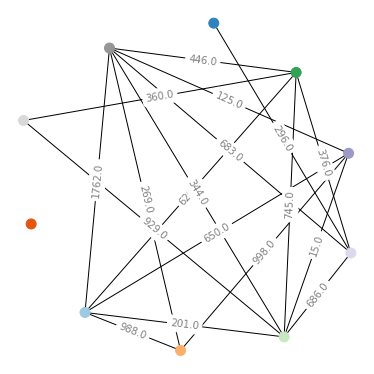

Topology # 2
   Best Clustering when K =  2
   Clustering: [0 1 0 0 0 1 0 0 0 0]
   F1 Score =  0.5619047619047619
   Cond. Entropy =  0.0
   Internal Traffic in Each Cluster: 
      C 0  =  8382.0  Mbps
      C 1  =  639.0  Mbps
   Total Emulated Traffic Between Clusters:  437.0


<Figure size 432x288 with 0 Axes>

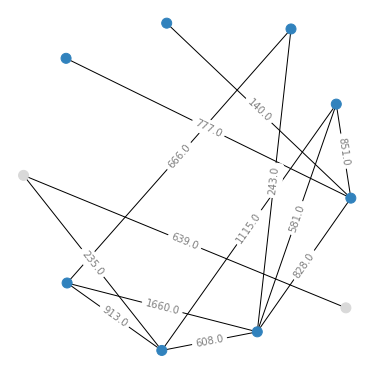

Topology # 3
   Best Clustering when K =  2
   Clustering: [0 0 1 1 1 0 0 1 0 0]
   F1 Score =  0.45714285714285713
   Cond. Entropy =  0.0
   Internal Traffic in Each Cluster: 
      C 0  =  5988.0  Mbps
      C 1  =  2653.0  Mbps
   Total Emulated Traffic Between Clusters:  2173.0


<Figure size 432x288 with 0 Axes>

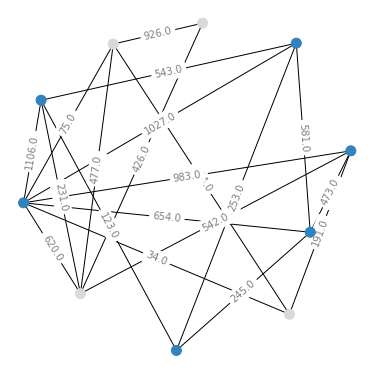

Topology # 4
   Best Clustering when K =  2
   Clustering: [0 0 0 0 0 0 0 1 1 0]
   F1 Score =  0.5619047619047619
   Cond. Entropy =  0.0
   Internal Traffic in Each Cluster: 
      C 0  =  7085.0  Mbps
      C 1  =  163.0  Mbps
   Total Emulated Traffic Between Clusters:  81.5


<Figure size 432x288 with 0 Axes>

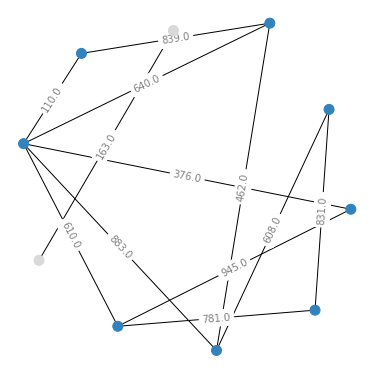

Topology # 5
   Best Clustering when K =  4
   Clustering: [0 1 2 1 3 3 3 2 0 3]
   F1 Score =  0.35333333333333333
   Cond. Entropy =  0.0
   Internal Traffic in Each Cluster: 
      C 0  =  1588.0  Mbps
      C 1  =  702.0  Mbps
      C 2  =  2029.0  Mbps
      C 3  =  2653.0  Mbps
   Total Emulated Traffic Between Clusters:  924.0


<Figure size 432x288 with 0 Axes>

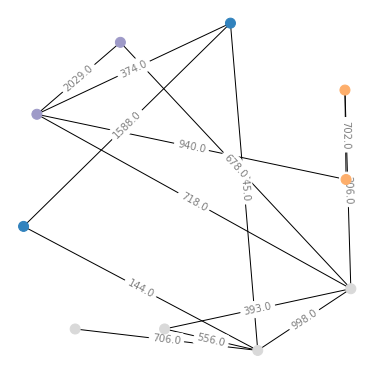

Topology # 6
   Best Clustering when K =  4
   Clustering: [0 1 0 2 2 1 3 0 3 0]
   F1 Score =  0.6190476190476191
   Cond. Entropy =  0.0
   Internal Traffic in Each Cluster: 
      C 0  =  1858.0  Mbps
      C 1  =  381.0  Mbps
      C 2  =  641.0  Mbps
      C 3  =  577.0  Mbps
   Total Emulated Traffic Between Clusters:  541.5


<Figure size 432x288 with 0 Axes>

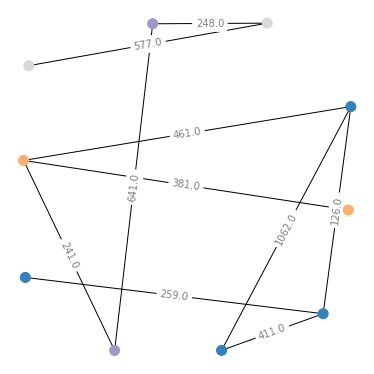

Topology # 7
   Best Clustering when K =  2
   Clustering: [0 0 0 0 0 0 0 1 0 0]
   F1 Score =  0.9473684210526315
   Cond. Entropy =  0.0
   Internal Traffic in Each Cluster: 
      C 0  =  3580.0  Mbps
      C 1  =  0.0  Mbps
   Total Emulated Traffic Between Clusters:  0.0


<Figure size 432x288 with 0 Axes>

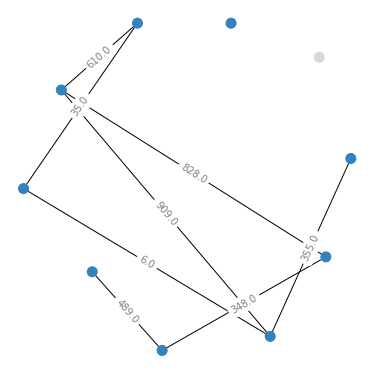

Topology # 8
   Best Clustering when K =  2
   Clustering: [0 0 1 1 0 0 1 1 1 0]
   F1 Score =  0.4
   Cond. Entropy =  0.0
   Internal Traffic in Each Cluster: 
      C 0  =  3144.0  Mbps
      C 1  =  4269.0  Mbps
   Total Emulated Traffic Between Clusters:  3270.0


<Figure size 432x288 with 0 Axes>

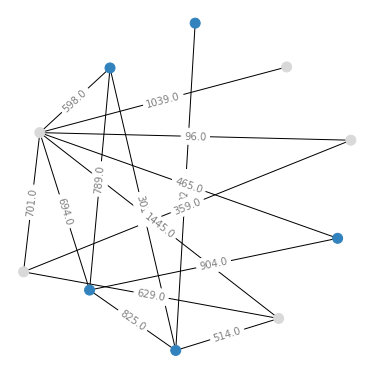

Topology # 9
   Best Clustering when K =  10
   Clustering: [0 1 2 3 4 5 6 7 8 9]
   F1 Score =  0.44333333333333336
   Cond. Entropy =  0.0
   Internal Traffic in Each Cluster: 
      C 0  =  0.0  Mbps
      C 1  =  0.0  Mbps
      C 2  =  0.0  Mbps
      C 3  =  0.0  Mbps
      C 4  =  0.0  Mbps
      C 5  =  0.0  Mbps
      C 6  =  0.0  Mbps
      C 7  =  0.0  Mbps
      C 8  =  0.0  Mbps
      C 9  =  0.0  Mbps
   Total Emulated Traffic Between Clusters:  961.0


<Figure size 432x288 with 0 Axes>

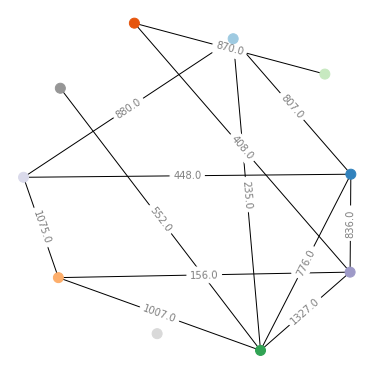

Topology # 10
   Best Clustering when K =  2
   Clustering: [0 0 0 1 0 0 0 0 0 0]
   F1 Score =  0.9473684210526315
   Cond. Entropy =  0.0
   Internal Traffic in Each Cluster: 
      C 0  =  5802.0  Mbps
      C 1  =  0.0  Mbps
   Total Emulated Traffic Between Clusters:  0.0


<Figure size 432x288 with 0 Axes>

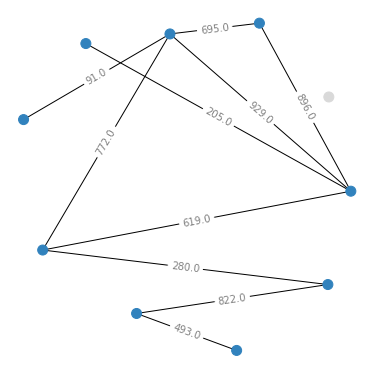

<Figure size 432x288 with 0 Axes>

In [0]:
for (cluster,k,f1,entropy,i) in zip(best_10, best_k_10, best_f1_10, best_entropy_10,range(len(best_10))):
  topology = x_10[i]
  print("Topology #",i+1)
  print("   Best Clustering when K = ",k)
  print("   Clustering:",cluster)
  print("   F1 Score = ",f1)
  print("   Cond. Entropy = ",entropy)
  cluster_distances = traffic(topology,cluster)
  print("   Internal Traffic in Each Cluster: ")
  for j in range(len(cluster_distances)):
    print("      C",j," = ",cluster_distances[j][0]," Mbps")
  print("   Total Emulated Traffic Between Clusters: ",0.5*sum(c for c in cluster_distances[:][1]))
  visualize2(x_10[i],cluster)


# ***Best Clustering in topologies with 50 nodes***

Topology # 1
   Best Clustering when K =  15
   Clustering: [ 0  1  2  3  2  4  3  4  5  5  6  3  6  7  0  8  9  2  6  3  6  4  3 10
  0  5 11  6  4  6  3  3  5 10 12  8  0  3  8  7  3 13  6  3  3  0  1 10
 14  3]
   F1 Score =  0.21722638146167558
   Cond. Entropy =  0.9101955000865392
   Internal Traffic in Each Cluster: 
      C 0  =  1998.0  Mbps
      C 1  =  246.0  Mbps
      C 2  =  160.0  Mbps
      C 3  =  7536.0  Mbps
      C 4  =  1893.0  Mbps
      C 5  =  2286.0  Mbps
      C 6  =  1801.0  Mbps
      C 7  =  802.0  Mbps
      C 8  =  1568.0  Mbps
      C 9  =  0.0  Mbps
      C 10  =  1397.0  Mbps
      C 11  =  0.0  Mbps
      C 12  =  0.0  Mbps
      C 13  =  0.0  Mbps
      C 14  =  0.0  Mbps
   Total Emulated Traffic Between Clusters:  149.0


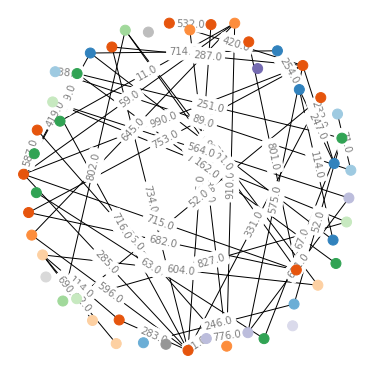

Topology # 2
   Best Clustering when K =  20
   Clustering: [ 0  1  2  3  4  5  6  1  7  8  4  9 10  6 11 12  8 11 13  9 14  2 15 16
 17  2  7 13 17 13  8 11 12  3 15 18 16  8 16 10 14 19 19 10  5 15 12  6
 18 17]
   F1 Score =  0.15200000000000002
   Cond. Entropy =  1.0203910001730776
   Internal Traffic in Each Cluster: 
      C 0  =  0.0  Mbps
      C 1  =  868.0  Mbps
      C 2  =  1633.0  Mbps
      C 3  =  997.0  Mbps
      C 4  =  714.0  Mbps
      C 5  =  558.0  Mbps
      C 6  =  1284.0  Mbps
      C 7  =  472.0  Mbps
      C 8  =  2909.0  Mbps
      C 9  =  828.0  Mbps
      C 10  =  1509.0  Mbps
      C 11  =  786.0  Mbps
      C 12  =  2062.0  Mbps
      C 13  =  1435.0  Mbps
      C 14  =  986.0  Mbps
      C 15  =  1477.0  Mbps
      C 16  =  1687.0  Mbps
      C 17  =  1504.0  Mbps
      C 18  =  723.0  Mbps
      C 19  =  760.0  Mbps
   Total Emulated Traffic Between Clusters:  1394.5


<Figure size 432x288 with 0 Axes>

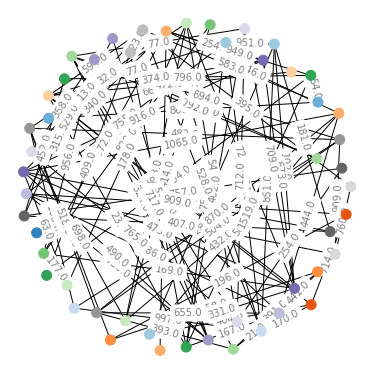

Topology # 3
   Best Clustering when K =  25
   Clustering: [ 0  1  2  3  4  5  6  7  2  8  9 10 11 12 11 13 14 15 14  6 12  4 16  5
  5  1 17 18 10 18 19 20 15 21 22 21 19 20 22 23 13  0 24 21  3 17 16  9
  8  6]
   F1 Score =  0.37799999999999995
   Cond. Entropy =  1.0452932501298084
   Internal Traffic in Each Cluster: 
      C 0  =  1256.0  Mbps
      C 1  =  633.0  Mbps
      C 2  =  840.0  Mbps
      C 3  =  1717.0  Mbps
      C 4  =  720.0  Mbps
      C 5  =  2044.0  Mbps
      C 6  =  2060.0  Mbps
      C 7  =  0.0  Mbps
      C 8  =  1544.0  Mbps
      C 9  =  1501.0  Mbps
      C 10  =  843.0  Mbps
      C 11  =  776.0  Mbps
      C 12  =  1176.0  Mbps
      C 13  =  772.0  Mbps
      C 14  =  1908.0  Mbps
      C 15  =  1329.0  Mbps
      C 16  =  1242.0  Mbps
      C 17  =  1079.0  Mbps
      C 18  =  915.0  Mbps
      C 19  =  1575.0  Mbps
      C 20  =  835.0  Mbps
      C 21  =  1127.0  Mbps
      C 22  =  921.0  Mbps
      C 23  =  0.0  Mbps
      C 24  =  0.0  Mbps
  

<Figure size 432x288 with 0 Axes>

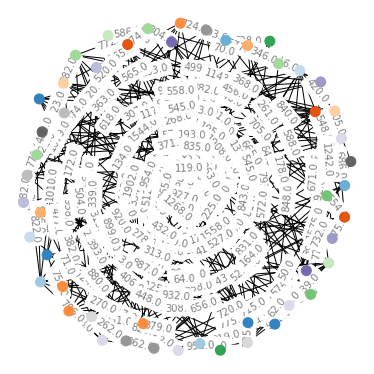

Topology # 4
   Best Clustering when K =  25
   Clustering: [ 0  1  2  3  4  5  2  6  7  8  9  6 10 11  8  7 12 13  1 14 11 15 12 16
  4 17  3 18 19 20 19 21 22 23 23 22  0 17 15 24 14 10 20 24  3 18  2 21
 16 23]
   F1 Score =  0.22
   Cond. Entropy =  1.0452932501298082
   Internal Traffic in Each Cluster: 
      C 0  =  1204.0  Mbps
      C 1  =  651.0  Mbps
      C 2  =  1538.0  Mbps
      C 3  =  2218.0  Mbps
      C 4  =  978.0  Mbps
      C 5  =  0.0  Mbps
      C 6  =  970.0  Mbps
      C 7  =  845.0  Mbps
      C 8  =  557.0  Mbps
      C 9  =  0.0  Mbps
      C 10  =  967.0  Mbps
      C 11  =  987.0  Mbps
      C 12  =  515.0  Mbps
      C 13  =  0.0  Mbps
      C 14  =  941.0  Mbps
      C 15  =  820.0  Mbps
      C 16  =  1004.0  Mbps
      C 17  =  537.0  Mbps
      C 18  =  1513.0  Mbps
      C 19  =  1531.0  Mbps
      C 20  =  584.0  Mbps
      C 21  =  848.0  Mbps
      C 22  =  782.0  Mbps
      C 23  =  1456.0  Mbps
      C 24  =  598.0  Mbps
   Total Emulated Traff

<Figure size 432x288 with 0 Axes>

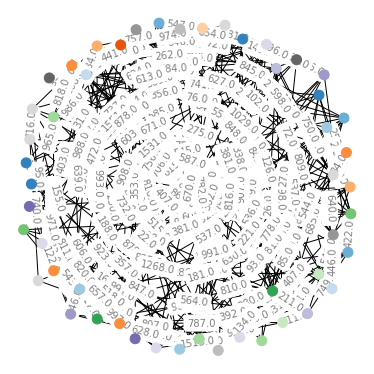

Topology # 5
   Best Clustering when K =  20
   Clustering: [ 0  1  2  3  4  5  6  7  8  9 10  9  6  8 11  3 10 12 13 12  4 13  9  6
  1  5 14 11 14  7  5 13  0  0 15  2 12 16 17  6  3  1 18  4 15 16 10 17
 18 19]
   F1 Score =  0.23531746031746031
   Cond. Entropy =  0.8603910001730776
   Internal Traffic in Each Cluster: 
      C 0  =  651.0  Mbps
      C 1  =  441.0  Mbps
      C 2  =  337.0  Mbps
      C 3  =  1471.0  Mbps
      C 4  =  1115.0  Mbps
      C 5  =  1608.0  Mbps
      C 6  =  1275.0  Mbps
      C 7  =  672.0  Mbps
      C 8  =  585.0  Mbps
      C 9  =  1063.0  Mbps
      C 10  =  730.0  Mbps
      C 11  =  85.0  Mbps
      C 12  =  1171.0  Mbps
      C 13  =  1486.0  Mbps
      C 14  =  407.0  Mbps
      C 15  =  399.0  Mbps
      C 16  =  781.0  Mbps
      C 17  =  768.0  Mbps
      C 18  =  995.0  Mbps
      C 19  =  0.0  Mbps
   Total Emulated Traffic Between Clusters:  779.0


<Figure size 432x288 with 0 Axes>

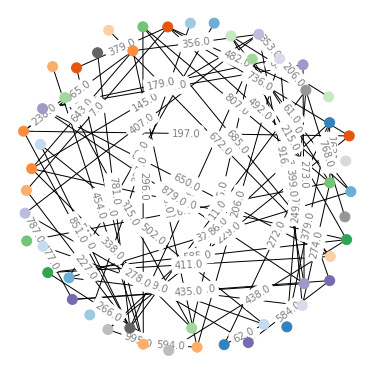

Topology # 6
   Best Clustering when K =  15
   Clustering: [ 0  1  2  1  3  0  4  5  6  0  4  1  7  3  8  9 10 10 11  8  2  8  3  9
 12 11 11  9 13  2  6  8 11 12 14  9 14 12  6 11  7 14  3  5  5  3  1  4
  0 11]
   F1 Score =  0.19898124098124095
   Cond. Entropy =  0.955488750216347
   Internal Traffic in Each Cluster: 
      C 0  =  2367.0  Mbps
      C 1  =  1879.0  Mbps
      C 2  =  1469.0  Mbps
      C 3  =  2289.0  Mbps
      C 4  =  1247.0  Mbps
      C 5  =  495.0  Mbps
      C 6  =  809.0  Mbps
      C 7  =  657.0  Mbps
      C 8  =  1739.0  Mbps
      C 9  =  2875.0  Mbps
      C 10  =  580.0  Mbps
      C 11  =  3884.0  Mbps
      C 12  =  1792.0  Mbps
      C 13  =  0.0  Mbps
      C 14  =  1701.0  Mbps
   Total Emulated Traffic Between Clusters:  2121.5


<Figure size 432x288 with 0 Axes>

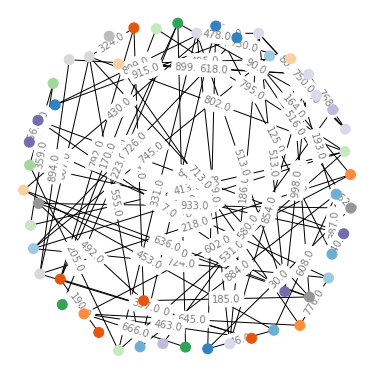

Topology # 7
   Best Clustering when K =  25
   Clustering: [ 0  1  2  3  4  5  6  7  8  9 10 11 12  4 13  7  1 14 15 16 12  9  5 17
 18 14 19 20 21 16 22 17 11 23  2 15  8  6 17 24 24  3 23 13 18 21  0  2
 19 11]
   F1 Score =  0.20590476190476192
   Cond. Entropy =  1.0052932501298082
   Internal Traffic in Each Cluster: 
      C 0  =  1331.0  Mbps
      C 1  =  334.0  Mbps
      C 2  =  1305.0  Mbps
      C 3  =  920.0  Mbps
      C 4  =  861.0  Mbps
      C 5  =  688.0  Mbps
      C 6  =  923.0  Mbps
      C 7  =  669.0  Mbps
      C 8  =  829.0  Mbps
      C 9  =  1781.0  Mbps
      C 10  =  0.0  Mbps
      C 11  =  1209.0  Mbps
      C 12  =  100.0  Mbps
      C 13  =  674.0  Mbps
      C 14  =  869.0  Mbps
      C 15  =  680.0  Mbps
      C 16  =  449.0  Mbps
      C 17  =  1334.0  Mbps
      C 18  =  994.0  Mbps
      C 19  =  837.0  Mbps
      C 20  =  0.0  Mbps
      C 21  =  540.0  Mbps
      C 22  =  0.0  Mbps
      C 23  =  991.0  Mbps
      C 24  =  652.0  Mbps
   Total E

<Figure size 432x288 with 0 Axes>

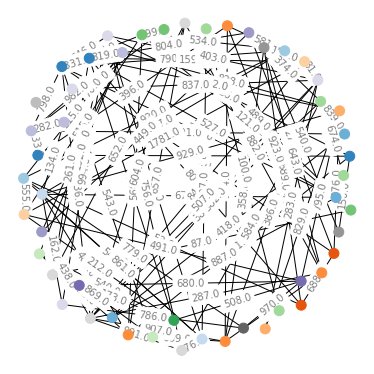

Topology # 8
   Best Clustering when K =  17
   Clustering: [ 0  1  2  3  4  5  4  6  7  8  1  9  7 10  0 11 12 13 12  5 14 14 15  6
  2 16 13  2  8 15  6 10  7  3 15  1 13 11  7  9 16  5 10  7 14  0 10 16
 12  9]
   F1 Score =  0.21600000000000003
   Cond. Entropy =  1.0452932501298084
   Internal Traffic in Each Cluster: 
      C 0  =  1126.0  Mbps
      C 1  =  2557.0  Mbps
      C 2  =  1644.0  Mbps
      C 3  =  804.0  Mbps
      C 4  =  1344.0  Mbps
      C 5  =  2632.0  Mbps
      C 6  =  1720.0  Mbps
      C 7  =  3631.0  Mbps
      C 8  =  875.0  Mbps
      C 9  =  2257.0  Mbps
      C 10  =  3855.0  Mbps
      C 11  =  787.0  Mbps
      C 12  =  1380.0  Mbps
      C 13  =  3531.0  Mbps
      C 14  =  1550.0  Mbps
      C 15  =  1599.0  Mbps
      C 16  =  1566.0  Mbps
   Total Emulated Traffic Between Clusters:  5845.0


<Figure size 432x288 with 0 Axes>

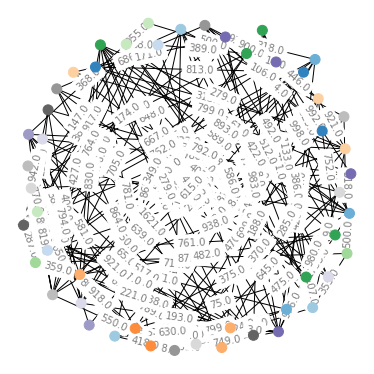

Topology # 9
   Best Clustering when K =  10
   Clustering: [0 1 2 1 3 2 4 5 3 3 6 7 1 5 6 6 0 6 1 6 7 6 3 7 3 2 8 1 8 5 6 7 7 7 5 6 6
 8 7 1 0 9 1 8 8 6 8 2 2 2]
   F1 Score =  0.17553346653346655
   Cond. Entropy =  0.9652932501298084
   Internal Traffic in Each Cluster: 
      C 0  =  1627.0  Mbps
      C 1  =  4132.0  Mbps
      C 2  =  3898.0  Mbps
      C 3  =  2977.0  Mbps
      C 4  =  0.0  Mbps
      C 5  =  3455.0  Mbps
      C 6  =  9387.0  Mbps
      C 7  =  4405.0  Mbps
      C 8  =  3350.0  Mbps
      C 9  =  0.0  Mbps
   Total Emulated Traffic Between Clusters:  5212.5


<Figure size 432x288 with 0 Axes>

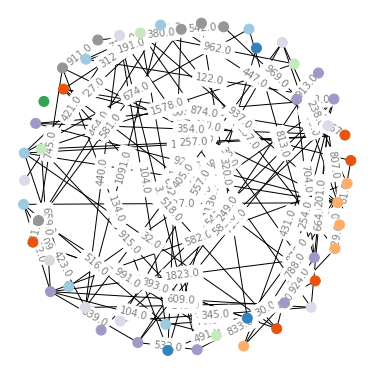

Topology # 10
   Best Clustering when K =  17
   Clustering: [ 0  1  2  3  4  5  0  6  7  8  9  2 10 11 12  5  2 13  7  5 13 11  6  4
  8  4  1 14  0  3  1  7  2  9  3 13 12 14  6  2  7 15 15 16  2  2 12 16
 10 15]
   F1 Score =  0.10800000000000001
   Cond. Entropy =  1.0052932501298084
   Internal Traffic in Each Cluster: 
      C 0  =  1822.0  Mbps
      C 1  =  1873.0  Mbps
      C 2  =  4458.0  Mbps
      C 3  =  1935.0  Mbps
      C 4  =  1889.0  Mbps
      C 5  =  1560.0  Mbps
      C 6  =  900.0  Mbps
      C 7  =  2063.0  Mbps
      C 8  =  1401.0  Mbps
      C 9  =  584.0  Mbps
      C 10  =  742.0  Mbps
      C 11  =  582.0  Mbps
      C 12  =  881.0  Mbps
      C 13  =  1299.0  Mbps
      C 14  =  405.0  Mbps
      C 15  =  1717.0  Mbps
      C 16  =  549.0  Mbps
   Total Emulated Traffic Between Clusters:  2230.5


<Figure size 432x288 with 0 Axes>

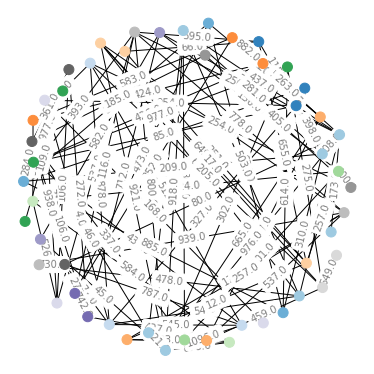

<Figure size 432x288 with 0 Axes>

In [0]:
for (cluster,k,f1,entropy,i) in zip(best_50, best_k_50, best_f1_50, best_entropy_50,range(len(best_50))):
  topology = x_50[i]
  print("Topology #",i+1)
  print("   Best Clustering when K = ",k)
  print("   Clustering:",cluster)
  print("   F1 Score = ",f1)
  print("   Cond. Entropy = ",entropy)
  cluster_distances = traffic(topology,cluster)
  print("   Internal Traffic in Each Cluster: ")
  for j in range(len(cluster_distances)):
    print("      C",j," = ",cluster_distances[j][0]," Mbps")
  print("   Total Emulated Traffic Between Clusters: ",0.5*sum(c for c in cluster_distances[:][1]))
  visualize2(x_50[i],cluster)

# ***Best Clustering in topologies with 100 nodes***

Topology # 1
   Best Clustering when K =  25
   Clustering: [ 0  1  2  3  4  5  6  7  7  8  5  9 10 11  4 12 13  3 14 15  0 16  3  1
 10  8 17  2 18 19 20 12  0 20 17 14  6  0 19  8  3  4 12 21  9 20 15 16
 11  2 22 19 23 15 12  8 11 12  5 15 16 13 24  9  8 14  9 19 12  8  2  9
 22 12  9  9 13 23  7 18  8 13 23 16 23 14 10  2 21 21 10  5 19  1 16 20
 24 21 24 18]
   Normalized Cut =  24.858435430701128
   Internal Traffic in Each Cluster: 
      C 0  =  3737.0  Mbps
      C 1  =  2481.0  Mbps
      C 2  =  6587.0  Mbps
      C 3  =  3888.0  Mbps
      C 4  =  2918.0  Mbps
      C 5  =  3116.0  Mbps
      C 6  =  1573.0  Mbps
      C 7  =  1038.0  Mbps
      C 8  =  9198.0  Mbps
      C 9  =  8086.0  Mbps
      C 10  =  2608.0  Mbps
      C 11  =  4176.0  Mbps
      C 12  =  6913.0  Mbps
      C 13  =  4869.0  Mbps
      C 14  =  2346.0  Mbps
      C 15  =  3199.0  Mbps
      C 16  =  5879.0  Mbps
      C 17  =  1592.0  Mbps
      C 18  =  1603.0  Mbps
      C 19  =  5054.0  Mbps
      

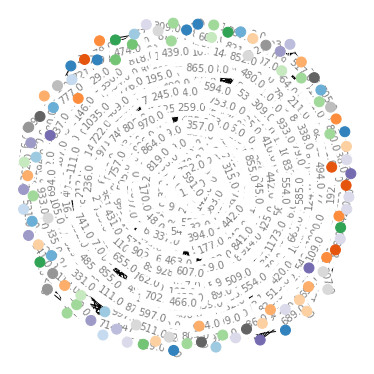

Topology # 2
   Best Clustering when K =  25
   Clustering: [ 0  1  2  3  4  5  6  7  8  2  9 10 11 12 13  4 14 15 13  4 15 14  1 16
 17  6 11  0 18 17  4  8 11 14  7 19 20 20  4  4 21  5  7 17  2  7 13 14
 10 18 18 20 12 10 22  9  9  5 20 23  1 18 18 22  1 10 22 22 14 15 23  9
 24 19 14  8  0 18 10 22  6  3  1 22 24 10  7 23 13 11 16 11 23 12 10 21
  3 11 12  7]
   Normalized Cut =  24.802183887696177
   Internal Traffic in Each Cluster: 
      C 0  =  3069.0  Mbps
      C 1  =  3744.0  Mbps
      C 2  =  2862.0  Mbps
      C 3  =  1514.0  Mbps
      C 4  =  3759.0  Mbps
      C 5  =  1685.0  Mbps
      C 6  =  1752.0  Mbps
      C 7  =  3960.0  Mbps
      C 8  =  1717.0  Mbps
      C 9  =  2635.0  Mbps
      C 10  =  2595.0  Mbps
      C 11  =  4473.0  Mbps
      C 12  =  2177.0  Mbps
      C 13  =  2428.0  Mbps
      C 14  =  3801.0  Mbps
      C 15  =  1312.0  Mbps
      C 16  =  1644.0  Mbps
      C 17  =  1789.0  Mbps
      C 18  =  3660.0  Mbps
      C 19  =  1596.0  Mbps
      

<Figure size 432x288 with 0 Axes>

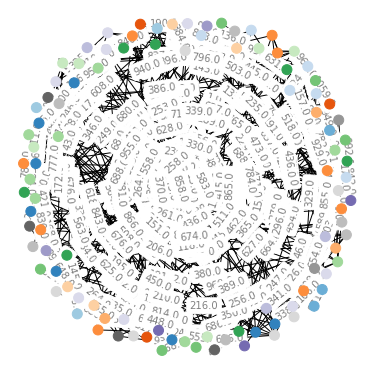

Topology # 3
   Best Clustering when K =  25
   Clustering: [ 0  1  2  3  4  5  6  7  3  8  6  9 10 11 12  8  2 13 14  5 15 13  6  9
 16  6 10 14  9 14  4 17 17 16 12 11 11 15 18  6 15  3 17 19 18  1  8 13
 20  7 19 11  0 18 17 21  1  5  2 12 22 23  3 13 24  4  0 22 22 10  8  9
 12  5 17 23 16 21 16  5  4 23 10 15 10 20 18 21 18 19 12 14 22 10 20 20
 21 12 14 17]
   Normalized Cut =  24.85663560228375
   Internal Traffic in Each Cluster: 
      C 0  =  3433.0  Mbps
      C 1  =  1994.0  Mbps
      C 2  =  2458.0  Mbps
      C 3  =  2686.0  Mbps
      C 4  =  3699.0  Mbps
      C 5  =  4123.0  Mbps
      C 6  =  5083.0  Mbps
      C 7  =  782.0  Mbps
      C 8  =  6009.0  Mbps
      C 9  =  2841.0  Mbps
      C 10  =  6362.0  Mbps
      C 11  =  3161.0  Mbps
      C 12  =  5408.0  Mbps
      C 13  =  2818.0  Mbps
      C 14  =  5785.0  Mbps
      C 15  =  4281.0  Mbps
      C 16  =  3368.0  Mbps
      C 17  =  6063.0  Mbps
      C 18  =  5031.0  Mbps
      C 19  =  2693.0  Mbps
      C 

<Figure size 432x288 with 0 Axes>

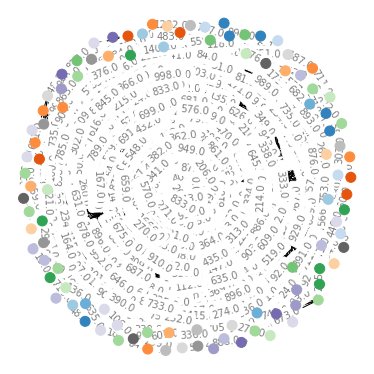

Topology # 4
   Best Clustering when K =  25
   Clustering: [ 0  1  2  3  0  4  5  6  7  8  6  9 10  1  1  2 11 12  8 13  3 14  8 10
 15 16  5 17 18  8  4 19 20 13 17 15  4 20 15 21 10 10 22  0 16 23 19 24
  6  9 16  3 16  6 15 13 16  1 11 16 10 14 21  3  5 10  4  5  9 17 16 12
  3  0  2  7 18  2 20 22  7  7 15 24  0 22  9 24 13  2 18 23  2 21  3 12
  1  9 14  0]
   Normalized Cut =  24.82833030299548
   Internal Traffic in Each Cluster: 
      C 0  =  6204.0  Mbps
      C 1  =  3803.0  Mbps
      C 2  =  5285.0  Mbps
      C 3  =  5938.0  Mbps
      C 4  =  2909.0  Mbps
      C 5  =  4433.0  Mbps
      C 6  =  3413.0  Mbps
      C 7  =  3494.0  Mbps
      C 8  =  2196.0  Mbps
      C 9  =  5664.0  Mbps
      C 10  =  7537.0  Mbps
      C 11  =  763.0  Mbps
      C 12  =  2152.0  Mbps
      C 13  =  4203.0  Mbps
      C 14  =  483.0  Mbps
      C 15  =  3174.0  Mbps
      C 16  =  7623.0  Mbps
      C 17  =  3078.0  Mbps
      C 18  =  3765.0  Mbps
      C 19  =  961.0  Mbps
      C 20

<Figure size 432x288 with 0 Axes>

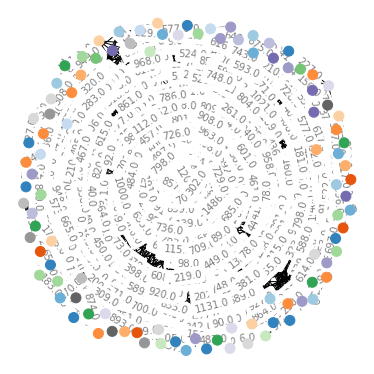

Topology # 5
   Best Clustering when K =  25
   Clustering: [ 0  1  2  0  3  1  0  3  0  4  5  6  7  4  8  0  9 10  8  7  0  7 11  4
 12  3  2  5  6 13 14  0  0 10  7  4 12  5  2 15  7 13 10  3 13  0  7  1
  8 16  0 13 17 10 18  0 19 10  7 20  5  0 15 21 22 21 12 17  9 12 12  4
  8  0 15 10  3 21  8  0 23 10  5  6 24  8  8  2 15 16  0  0  0  8  0  3
 12  0 15 16]
   Normalized Cut =  24.738099171830946
   Internal Traffic in Each Cluster: 
      C 0  =  10878.0  Mbps
      C 1  =  1342.0  Mbps
      C 2  =  1664.0  Mbps
      C 3  =  3090.0  Mbps
      C 4  =  2781.0  Mbps
      C 5  =  2806.0  Mbps
      C 6  =  1618.0  Mbps
      C 7  =  4380.0  Mbps
      C 8  =  5584.0  Mbps
      C 9  =  876.0  Mbps
      C 10  =  5032.0  Mbps
      C 11  =  0.0  Mbps
      C 12  =  3861.0  Mbps
      C 13  =  1951.0  Mbps
      C 14  =  0.0  Mbps
      C 15  =  4595.0  Mbps
      C 16  =  1666.0  Mbps
      C 17  =  339.0  Mbps
      C 18  =  0.0  Mbps
      C 19  =  0.0  Mbps
      C 20  =  0.0 

<Figure size 432x288 with 0 Axes>

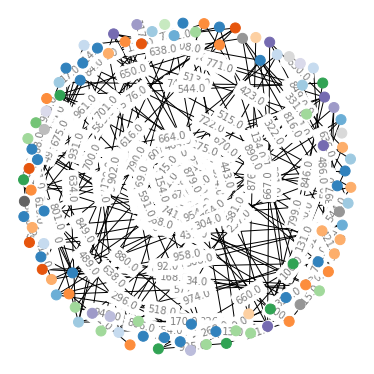

Topology # 6
   Best Clustering when K =  25
   Clustering: [ 0  1  2  3  4  5  2  4  6  7  4  5  8  8  9 10  3 11 12 13  0 14 14 15
  5 16  3 17 16 13  3  4  0  1 18 19 13 20 12 21 22 23 16  3 19 22 20  4
  3 15 11 18 16 19  4  5  6 19 16 22 11 16 18  2 17 17 22 10  2  1 15 20
 21  5 16 14  9 24 24  4 14 22  4  8 16  7  4 16  6  8  7 24 18  3 22 23
 23 15 20 13]
   Normalized Cut =  24.833489959829883
   Internal Traffic in Each Cluster: 
      C 0  =  1963.0  Mbps
      C 1  =  3486.0  Mbps
      C 2  =  2703.0  Mbps
      C 3  =  7519.0  Mbps
      C 4  =  9741.0  Mbps
      C 5  =  3743.0  Mbps
      C 6  =  3121.0  Mbps
      C 7  =  1961.0  Mbps
      C 8  =  2370.0  Mbps
      C 9  =  837.0  Mbps
      C 10  =  1506.0  Mbps
      C 11  =  2226.0  Mbps
      C 12  =  2007.0  Mbps
      C 13  =  3486.0  Mbps
      C 14  =  2256.0  Mbps
      C 15  =  4539.0  Mbps
      C 16  =  12486.0  Mbps
      C 17  =  1944.0  Mbps
      C 18  =  4674.0  Mbps
      C 19  =  2119.0  Mbps
      

<Figure size 432x288 with 0 Axes>

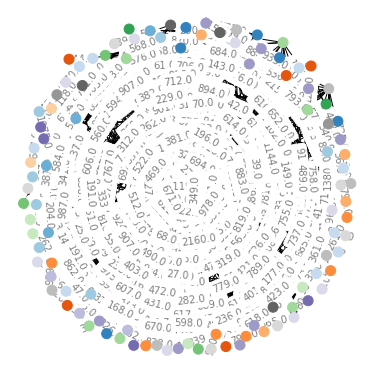

Topology # 7
   Best Clustering when K =  25
   Clustering: [ 0  1  2  3  4  5  6  7  0  8  8  9 10 11 12  4 12  9 13  0 14  7 15  4
 16  6  2  2 17  9 18 18  0  4 19 15  3 16 20 20  9 21 15 17  2 22 23 11
  5  1  0 10 22 15 18 13  5 12 11  5 10 13 14 19  2 12  0  6 11 17 15 22
  4  0 18 23  0  7  7 20 14 22 13 20  5 24 11  1 19 24 22 23  8 14 19 21
 24 21 21  7]
   Normalized Cut =  24.867790598922955
   Internal Traffic in Each Cluster: 
      C 0  =  10178.0  Mbps
      C 1  =  2178.0  Mbps
      C 2  =  4368.0  Mbps
      C 3  =  1467.0  Mbps
      C 4  =  6328.0  Mbps
      C 5  =  4890.0  Mbps
      C 6  =  2279.0  Mbps
      C 7  =  7901.0  Mbps
      C 8  =  3270.0  Mbps
      C 9  =  3812.0  Mbps
      C 10  =  2284.0  Mbps
      C 11  =  4880.0  Mbps
      C 12  =  4292.0  Mbps
      C 13  =  4083.0  Mbps
      C 14  =  3420.0  Mbps
      C 15  =  5883.0  Mbps
      C 16  =  1704.0  Mbps
      C 17  =  1873.0  Mbps
      C 18  =  2329.0  Mbps
      C 19  =  3894.0  Mbps
     

<Figure size 432x288 with 0 Axes>

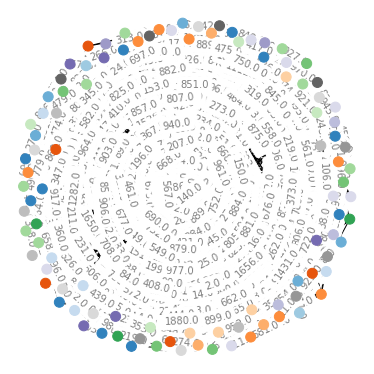

Topology # 8
   Best Clustering when K =  25
   Clustering: [ 0  1  2  3  4  5  6  7  8  4  5  9 10 11 12 11  6  6 13 14 15  9 16 17
 18  5 18 12 15  7  8 18  0 19  2 15 19 10 17  4  0 19 20 18  1  2  1  2
 21 20 15 22  5 13 15  5  6  8 23  3 18  7 18  9 18 10 14 23 24  6  6 18
  9 24  8 18 22 20 10 15 18 15 17 10  4 22 16  1 19 13  4  1 10 14 10 21
 22 15 13 18]
   Normalized Cut =  24.800619621524778
   Internal Traffic in Each Cluster: 
      C 0  =  1262.0  Mbps
      C 1  =  4830.0  Mbps
      C 2  =  2187.0  Mbps
      C 3  =  662.0  Mbps
      C 4  =  4254.0  Mbps
      C 5  =  4631.0  Mbps
      C 6  =  5102.0  Mbps
      C 7  =  1370.0  Mbps
      C 8  =  2514.0  Mbps
      C 9  =  3717.0  Mbps
      C 10  =  3441.0  Mbps
      C 11  =  800.0  Mbps
      C 12  =  907.0  Mbps
      C 13  =  3434.0  Mbps
      C 14  =  1582.0  Mbps
      C 15  =  4467.0  Mbps
      C 16  =  1247.0  Mbps
      C 17  =  1953.0  Mbps
      C 18  =  7097.0  Mbps
      C 19  =  2129.0  Mbps
      C 2

<Figure size 432x288 with 0 Axes>

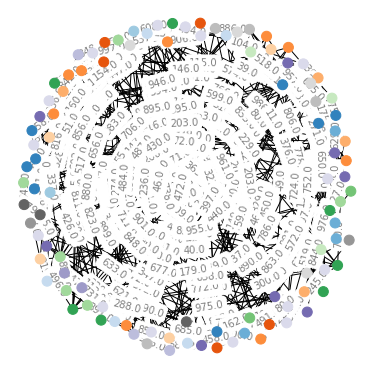

Topology # 9
   Best Clustering when K =  25
   Clustering: [ 0  1  2  3  4  5  6  7  8  9  6 10 11 12 13  9 14 11 15 15 16 17  4 18
 19  4 11 12 20 21  8  5  2 13 22 14  3 20  7 10 14 19 16 20  7 21  8 23
 14  5 17  7 21  0 22  9 14 16 11 23  9 16 10 14 13 22 13 22  1  8  9  6
  7 16 10 18 24 10  6 14  2 17 14 22  6  0 12  3 22 19  1 10 12 21  6 23
 12 15  0  0]
   Normalized Cut =  24.82619161215996
   Internal Traffic in Each Cluster: 
      C 0  =  2772.0  Mbps
      C 1  =  1778.0  Mbps
      C 2  =  2121.0  Mbps
      C 3  =  1519.0  Mbps
      C 4  =  2041.0  Mbps
      C 5  =  2329.0  Mbps
      C 6  =  5230.0  Mbps
      C 7  =  3248.0  Mbps
      C 8  =  2631.0  Mbps
      C 9  =  4673.0  Mbps
      C 10  =  5453.0  Mbps
      C 11  =  3770.0  Mbps
      C 12  =  4037.0  Mbps
      C 13  =  2621.0  Mbps
      C 14  =  7852.0  Mbps
      C 15  =  2290.0  Mbps
      C 16  =  6313.0  Mbps
      C 17  =  1692.0  Mbps
      C 18  =  1442.0  Mbps
      C 19  =  1463.0  Mbps
      C

<Figure size 432x288 with 0 Axes>

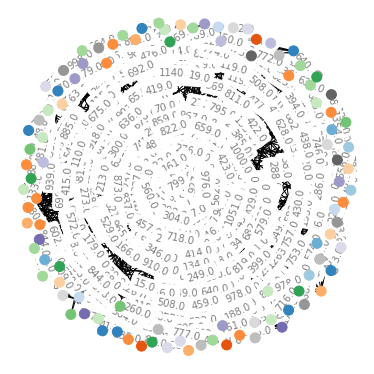

Topology # 10
   Best Clustering when K =  25
   Clustering: [ 0  1  2  3  4  5  6  7  8  4  9  1  0 10  5 11 12  8 13 14  4 15 16 11
  2 17  2  0 18 17  5 14 14 13 11  5  7 16 15 14 19 19  8 15 18 20 14 10
 12  7 14  9 14 14 16  1 14 14 14 21 20 20 14 22 21  6 23 17  5 24 22  3
 13 22  1  4 12 20 15  9 21 24  9 19 23  2  3 17 12  8 10  3 18 24 24 11
 21  8  1 22]
   Normalized Cut =  24.815027634550848
   Internal Traffic in Each Cluster: 
      C 0  =  1046.0  Mbps
      C 1  =  3196.0  Mbps
      C 2  =  1827.0  Mbps
      C 3  =  3096.0  Mbps
      C 4  =  2130.0  Mbps
      C 5  =  3414.0  Mbps
      C 6  =  740.0  Mbps
      C 7  =  1853.0  Mbps
      C 8  =  2486.0  Mbps
      C 9  =  2991.0  Mbps
      C 10  =  1488.0  Mbps
      C 11  =  1881.0  Mbps
      C 12  =  2165.0  Mbps
      C 13  =  1369.0  Mbps
      C 14  =  8622.0  Mbps
      C 15  =  3176.0  Mbps
      C 16  =  1690.0  Mbps
      C 17  =  2554.0  Mbps
      C 18  =  2174.0  Mbps
      C 19  =  1608.0  Mbps
      

<Figure size 432x288 with 0 Axes>

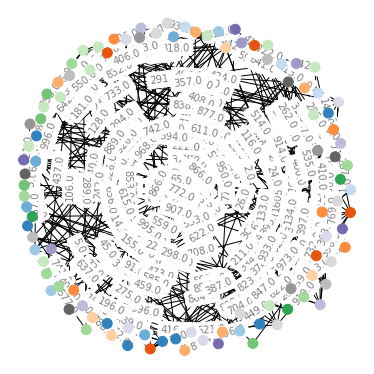

<Figure size 432x288 with 0 Axes>

In [0]:
for (cluster,k,nc,i) in zip(best_100, best_k_100, best_nc,range(len(best_100))):
  topology = x_100[i]
  print("Topology #",i+1)
  print("   Best Clustering when K = ",k)
  print("   Clustering:",cluster)
  print("   Normalized Cut = ",nc)
  cluster_distances = traffic(topology,cluster)
  print("   Internal Traffic in Each Cluster: ")
  for j in range(len(cluster_distances)):
    print("      C",j," = ",cluster_distances[j][0]," Mbps")
  print("   Total Emulated Traffic Between Clusters: ",0.5*sum(c for c in cluster_distances[:][1]))

  visualize2(x_100[i],cluster)